In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Get Dataset

In [24]:
German = pd.read_csv('train.csv')
German.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15772896.0,Pritchard,535.0,France,Male,44.0,8.0,108393.35,1.0,1.0,1.0,127528.84,0.0
1,1,15758063.0,Nkemakolam,549.0,France,Male,38.0,8.0,0.00,2.0,1.0,1.0,146891.07,0.0
2,2,15767231.0,Genovese,641.0,France,Male,34.0,5.0,0.00,2.0,0.0,1.0,171922.72,0.0
3,3,15762543.0,Nnachetam,692.0,Germany,Female,34.0,7.0,78892.23,1.0,1.0,1.0,121592.50,0.0
4,4,15747358.0,Chinwemma,681.0,France,Male,41.0,5.0,0.00,2.0,0.0,0.0,100791.36,0.0


In [25]:
#Setting id as Index
German.set_index('id', inplace=True)

In [26]:
German.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       15000 non-null  float64
 1   Surname          15000 non-null  object 
 2   CreditScore      15000 non-null  float64
 3   Geography        15000 non-null  object 
 4   Gender           15000 non-null  object 
 5   Age              15000 non-null  float64
 6   Tenure           15000 non-null  float64
 7   Balance          15000 non-null  float64
 8   NumOfProducts    15000 non-null  float64
 9   HasCrCard        15000 non-null  float64
 10  IsActiveMember   15000 non-null  float64
 11  EstimatedSalary  15000 non-null  float64
 12  Exited           15000 non-null  float64
dtypes: float64(10), object(3)
memory usage: 1.6+ MB


In [27]:
German['CustomerId'].value_counts()

CustomerId
15641640.0    20
15662494.0    18
15686963.0    17
15587562.0    16
15793331.0    16
              ..
15801296.0     1
15598700.0     1
15615296.0     1
15762855.0     1
15700714.0     1
Name: count, Length: 6357, dtype: int64

In [28]:
German['Exited'].value_counts()

Exited
0.0    11970
1.0     3030
Name: count, dtype: int64

## Preprocessing

In [29]:
#Dropping Surname column
German.drop(columns=['Surname', 'CustomerId'], inplace=True)

In [30]:
German['IsSenior'] = German['Age'].apply(lambda x: 1 if x >= 60 else 0)
German['IsActive_by_CreditCard'] = German['HasCrCard'] * German['IsActiveMember']
German['Products_Per_Tenure'] =  German['Tenure'] / German['NumOfProducts']

In [31]:
German.isnull().sum()

CreditScore               0
Geography                 0
Gender                    0
Age                       0
Tenure                    0
Balance                   0
NumOfProducts             0
HasCrCard                 0
IsActiveMember            0
EstimatedSalary           0
Exited                    0
IsSenior                  0
IsActive_by_CreditCard    0
Products_Per_Tenure       0
dtype: int64

## Data Distribution

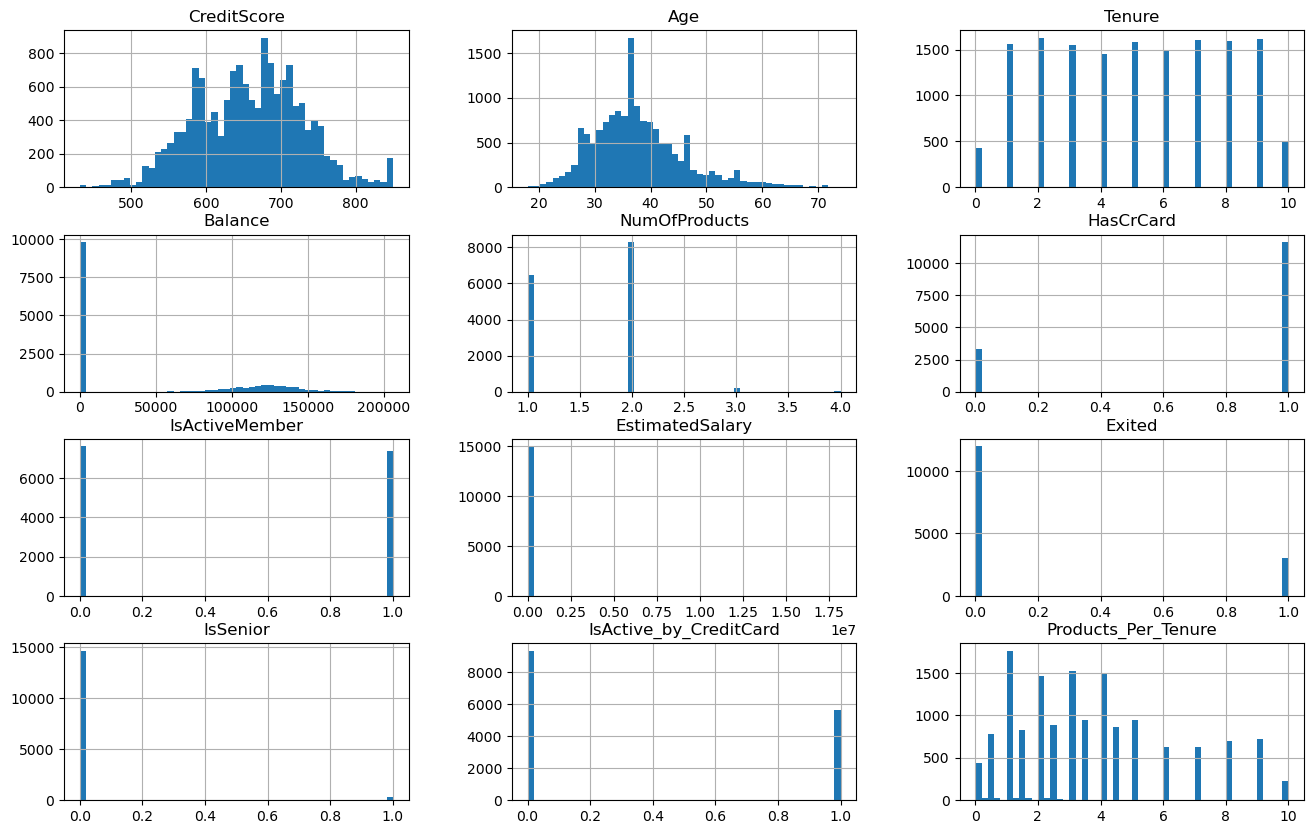

In [32]:
German.hist(bins=50, figsize=(16,10))
plt.show()

## Train-valid split

In [33]:
from sklearn.model_selection import train_test_split

X=German.drop(columns=['Exited'])
y=German['Exited']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=0)

In [34]:
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')

X_train shape: (11250, 13)
X_valid shape: (3750, 13)
y_train shape: (11250,)
y_valid shape: (3750,)


## Pipeline

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, QuantileTransformer, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer


### Creating attributes

In [36]:
X_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure'],
      dtype='object')

In [37]:
power_attrs = ['Age'] #skewed 
quant_attrs = ['CreditScore', 'Tenure', 'Products_Per_Tenure']
numeric_attrs = ['Balance','NumOfProducts','HasCrCard', 'IsActiveMember', 'EstimatedSalary', 
                 'IsSenior', 'IsActive_by_CreditCard', ]
cat_attrs = ['Geography', 'Gender']

### Creating pipelines

In [38]:
quant_pipeline = Pipeline([('quantile transformer', QuantileTransformer(n_quantiles=100)), ('standard scaler', StandardScaler())])
power_pipeline = Pipeline([('power transform', PowerTransformer(method = 'box-cox'))])
cat_pipeline = Pipeline([("categorical transform", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
numperic_pipeline = Pipeline([("numeric transform", StandardScaler())])

preprocessing = ColumnTransformer([
    ('numeric', 'passthrough', numeric_attrs),
    ('quant', quant_pipeline, quant_attrs),
    ('power', power_pipeline, power_attrs),
    ('cat', cat_pipeline, cat_attrs)
])

## HyperParameter Optimization

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score


### Grid Search for hyperparameter optimization

In [40]:
classifiers = {
    'logisticregression': LogisticRegression(max_iter=1000, random_state=42),
    'randomforest': RandomForestClassifier(random_state=42),
    'gradientboosting': GradientBoostingClassifier(random_state=42),
    'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'lightgbm': LGBMClassifier(random_state=42),
    'catboost': CatBoostClassifier(verbose=0, random_state=42),
    'decisiontree': DecisionTreeClassifier(random_state=42),
    'adaboost': AdaBoostClassifier(random_state=42)
}

In [41]:
param_grids = {
    'logisticregression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    },
    'randomforest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [10, 20, 30, 40],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'gradientboosting': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [10, 20, 30, 40],
        'classifier__subsample': [0.8, 0.9, 1.0]
    },
    'xgboost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [5, 15, 20, 25],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0]
    },
    'lightgbm': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__num_leaves': [31, 50, 100],
        'classifier__subsample': [0.8, 0.9, 1.0]
    },
    'catboost': {
        'classifier__iterations': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__depth': [5, 15, 20, 25]
    },
    'decisiontree': {
        'classifier__max_depth': [10, 20, 30, 40],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'adaboost': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0]
    }
}

In [42]:
from sklearn.model_selection import KFold
# Create a scoring function for evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Iterate through the classifiers and perform hyperparameter optimization
best_models_grid = {}
for name, classifier in classifiers.items():
    print(f"Optimizing {name}...")
    pipe = Pipeline(steps=[('preprocessing', preprocessing), ('classifier', classifier)])
    search = GridSearchCV(pipe, param_grids[name], cv=kf, scoring='roc_auc', n_jobs=-1)
    search.fit(X_train, y_train)
    best_models_grid[name] = search.best_estimator_
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best ROC AUC for {name}: {search.best_score_}\n")

Optimizing logisticregression...
Best parameters for logisticregression: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best ROC AUC for logisticregression: 0.8829457351627564

Optimizing randomforest...
Best parameters for randomforest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best ROC AUC for randomforest: 0.9265042599713791

Optimizing gradientboosting...
Best parameters for gradientboosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 10, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}
Best ROC AUC for gradientboosting: 0.9205662422267309

Optimizing xgboost...


C:\Users\vijay\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for xgboost: {'classifier__colsample_bytree': 0.9, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
Best ROC AUC for xgboost: 0.9293612391378211

Optimizing lightgbm...
[LightGBM] [Info] Number of positive: 2273, number of negative: 8977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 879
[LightGBM] [Info] Number of data points in the train set: 11250, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202044 -> initscore=-1.373565
[LightGBM] [Info] Start training from score -1.373565
Best parameters for lightgbm: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 300, 'classifier__num_leaves': 31, 'classifier__subsample': 0.8}
Best ROC AUC for lightgbm: 0.9282908019475634

Optimiz

C:\Users\vijay\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vijay\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vijay\anaconda3\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\vijay\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fi

Best parameters for catboost: {'classifier__depth': 5, 'classifier__iterations': 100, 'classifier__learning_rate': 0.2}
Best ROC AUC for catboost: 0.9316979210868294

Optimizing decisiontree...
Best parameters for decisiontree: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best ROC AUC for decisiontree: 0.8663953906455489

Optimizing adaboost...
Best parameters for adaboost: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Best ROC AUC for adaboost: 0.9245268977560521



In [43]:
# Evaluate the best models on the test set
for name, model in best_models_grid.items():
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)
    print(f"{name} - Valid Set Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}\n")

logisticregression - Valid Set Performance:
Accuracy: 0.88
F1 Score: 0.65
ROC AUC Score: 0.76

randomforest - Valid Set Performance:
Accuracy: 0.90
F1 Score: 0.71
ROC AUC Score: 0.80

gradientboosting - Valid Set Performance:
Accuracy: 0.89
F1 Score: 0.70
ROC AUC Score: 0.79

xgboost - Valid Set Performance:
Accuracy: 0.90
F1 Score: 0.72
ROC AUC Score: 0.80

lightgbm - Valid Set Performance:
Accuracy: 0.90
F1 Score: 0.72
ROC AUC Score: 0.80

catboost - Valid Set Performance:
Accuracy: 0.90
F1 Score: 0.72
ROC AUC Score: 0.80

decisiontree - Valid Set Performance:
Accuracy: 0.87
F1 Score: 0.67
ROC AUC Score: 0.78

adaboost - Valid Set Performance:
Accuracy: 0.89
F1 Score: 0.71
ROC AUC Score: 0.80



##### Voting classifier (grid search)

In [44]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
voting_clf = VotingClassifier(
    estimators=[(name, best_model) for name, best_model in best_models_grid.items()],
    voting='soft'
)

# Fit the ensemble model
voting_clf.fit(X_train, y_train)

y_pred_prob = voting_clf.predict_proba(X_valid)[:, 1]

# Evaluate the ensemble model on the test set
accuracy = accuracy_score(y_valid, voting_clf.predict(X_valid))
f1 = f1_score(y_valid, voting_clf.predict(X_valid))
roc_auc = roc_auc_score(y_valid, y_pred_prob)

print(f"Ensemble Model - Valid Set Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

C:\Users\vijay\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:52:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 2273, number of negative: 8977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 879
[LightGBM] [Info] Number of data points in the train set: 11250, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202044 -> initscore=-1.373565
[LightGBM] [Info] Start training from score -1.373565
Ensemble Model - Valid Set Performance:
Accuracy: 0.90
F1 Score: 0.72
ROC AUC Score: 0.93


##### Stacking (Grid search)

In [45]:
sclf1 = StackingClassifier(estimators=[(name, best_model) for name, best_model in best_models_grid.items()])
sclf1 = sclf1.fit(X_train, y_train)
accuracy_sclf1 = sclf1.score(X_valid, y_valid)

C:\Users\vijay\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 2273, number of negative: 8977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 879
[LightGBM] [Info] Number of data points in the train set: 11250, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202044 -> initscore=-1.373565
[LightGBM] [Info] Start training from score -1.373565


C:\Users\vijay\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\vijay\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\vijay\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\vijay\anaconda3\Lib\site-packages\

[LightGBM] [Info] Number of positive: 1818, number of negative: 7182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202000 -> initscore=-1.373841
[LightGBM] [Info] Start training from score -1.373841
[LightGBM] [Info] Number of positive: 1818, number of negative: 7182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202000 -> initscore=-1.373841
[LightGBM]

In [46]:
# Make predictions and output probabilities
y_pred_prob_stack = sclf1.predict_proba(X_valid)[:, 1]

# Round the probabilities to one decimal place
y_pred_prob_stack_rounded = np.round(y_pred_prob_stack, 1)

In [47]:
# Evaluate the stacking model on the test set
accuracy_stack = accuracy_score(y_valid, sclf1.predict(X_valid))
f1_stack = f1_score(y_valid, sclf1.predict(X_valid))
roc_auc_stack = roc_auc_score(y_valid, y_pred_prob_stack)

print(f"Stacking Model - Valid Set Performance:")
print(f"Accuracy: {accuracy_stack:.2f}")
print(f"F1 Score: {f1_stack:.2f}")
print(f"ROC AUC Score: {roc_auc_stack:.2f}")

Stacking Model - Valid Set Performance:
Accuracy: 0.90
F1 Score: 0.72
ROC AUC Score: 0.93


## Creating predictions

In [48]:
X_test = pd.read_csv('test (2).csv')
X_test.set_index('id', inplace=True)

#Creating new features
X_test['IsSenior'] = X_test['Age'].apply(lambda x: 1 if x >= 60 else 0)
X_test['IsActive_by_CreditCard'] = X_test['HasCrCard'] * X_test['IsActiveMember']
X_test['Products_Per_Tenure'] =  X_test['Tenure'] / X_test['NumOfProducts']

#Dropping Surname column
X_test.drop(columns=['Surname', 'CustomerId'], inplace=True)

In [49]:
X_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure
id,,,,,,,,,,,,,
15000,661.0,Germany,Male,32.0,5.0,113715.36,2.0,1.0,1.0,55816.20,0,1.0,2.5
15001,525.0,Spain,Female,37.0,3.0,0.00,2.0,0.0,1.0,160129.99,0,0.0,1.5
15002,585.0,Spain,Male,42.0,7.0,0.00,2.0,0.0,1.0,126160.24,0,0.0,3.5
15003,634.0,France,Male,39.0,2.0,0.00,2.0,1.0,0.0,163714.92,0,0.0,1.0
15004,546.0,France,Male,40.0,5.0,114318.23,1.0,0.0,0.0,189558.44,0,0.0,5.0


#### Voting classifier predictions (without Knn)

In [50]:
final_predictions_vote = voting_clf.predict_proba(X_test)[:, 1]
final_predictions_vote_rounded = np.round(final_predictions_vote, 1)

id = X_test.index
predictions_df_vote = pd.DataFrame({'id': id, 'Exiting': final_predictions_vote_rounded})
predictions_df_vote.to_csv('customerchurn_predictions_voting_grid_try.csv', index=False)

#### Stacking predictions (without Knn)

In [51]:
final_predictions_vote = sclf1.predict_proba(X_test)[:, 1]
final_predictions_vote_rounded = np.round(final_predictions_vote, 1)

id = X_test.index
predictions_df_vote = pd.DataFrame({'id': id, 'Exiting': final_predictions_vote_rounded})
predictions_df_vote.to_csv('customerchurn_predictions_stacking_grid_try.csv', index=False)